In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset


In [20]:
prob = .25
dropout = nn.Dropout(p = prob)
x = torch.ones(10)


y = dropout(x)

print(x)
print(y)#*(1-prob)
print(torch.mean(y))#*(1-prob)


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1.3333, 0.0000, 0.0000, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333,
        1.3333])
tensor(1.0667)


In [21]:
# dropout is turned off when eval
dropout.eval()
y = dropout(x)
print(y)
print(torch.mean(y))




dropout.eval()
y = F.dropout(x)
print(y)
print(torch.mean(y))


# Observation: F.dropout is not deactivated in eval mode

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)
tensor([0., 0., 0., 0., 0., 2., 2., 2., 0., 0.])
tensor(0.6000)


In [22]:
y = F.dropout(x,training=False)

print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [23]:
dropout.train()
y = dropout(x)
print(y) # with dropout


dropout.eval()
y = dropout(x)
print(y) # without dropout


tensor([1.3333, 0.0000, 0.0000, 1.3333, 1.3333, 1.3333, 1.3333, 1.3333, 0.0000,
        1.3333])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


### Example

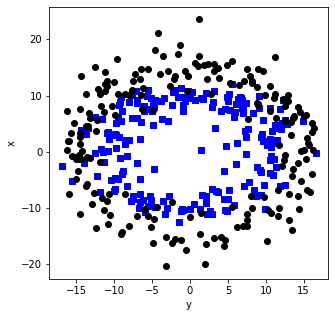

In [24]:
# not the best idea to solve this kind of problem with deep learning, but it not bad to train 
nPerClust = 200

th = np.linspace(0,5*np.pi,nPerClust)
r1 = 10
r2 = 15


a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]


labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))
data_np = np.hstack((a,b)).T
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()


fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.xlabel('y')
plt.ylabel('x')
plt.show()

In [25]:
# path: scikit train_test_split -> TensorDataset -> DataLoader
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# converted to tensors
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# create a dataloader - batch size of 12
batchsize    = 16 
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # batch_size = number of samples

In [26]:
class ModelWithDropout(nn.Module):

    def __init__(self,dropoutRate):
        super().__init__()

        # layers
        self.input  = nn.Linear(  2,128)
        self.hidden = nn.Linear(128,128)
        self.output = nn.Linear(128, 1)

        self.dropout = dropoutRate

    def forward(self,x):
        #  input
        x = F.relu( self.input(x) )
        x = F.dropout(x,p=self.dropout,training=self.training) 

        # hidden
        x = F.relu( self.hidden(x) )
        x = F.dropout(x,p=self.dropout,training=self.training) 

        # output layer
        x = self.output(x)
        
        return x


In [27]:
def createModel(dropoutrate):

  # grab an instance of the model class
  ANN = ModelWithDropout(dropoutrate)

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANN.parameters(),lr=.002)

  return ANN,lossfun,optimizer

In [28]:

numepochs = 1000

In [29]:


def trainTheModel(ANNQC,lossfun,optimizer):

  # (not storing losses here)
  trainAcc = []
  testAcc  = []


  # training mode: on
  ANNQC.train() 

  # loop over epochs
  for _ in range(numepochs):

    

    # accuracy for each batch will be sotred here
    batchAcc = []


    for X,y in train_loader:

     
      yHat = ANNQC(X)
      loss = lossfun(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      
      batchAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )
    

    
    trainAcc.append( np.mean(batchAcc) )

    # test accuracy
    # training mode: off
    ANNQC.eval() 
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = ANNQC(X)
    testAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )
    ANNQC.train() #this could be here too
  
  return trainAcc,testAcc


In [30]:
dropoutrate = .0
ANNQC,lossfun,optimizer = createModel(dropoutrate)

# train the model (note the inputs!)
trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

In [31]:
# print(trainAcc,testAcc)

In [32]:
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')

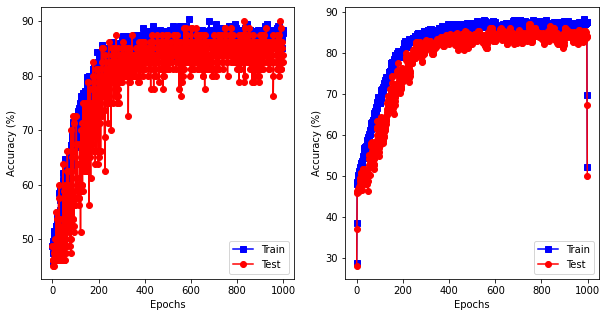

In [33]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

# plt.plot(smooth(trainAcc),'bs-')
# plt.plot(smooth(testAcc),'ro-')
ax[0].plot(trainAcc,'bs-')
ax[0].plot(testAcc,'ro-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy (%)')
ax[0].legend(['Train','Test'])
# ax[0].title('Dropout rate = %g'%dropoutrate)

# smooth only for better visualization
ax[1].plot(smooth(trainAcc),'bs-')
ax[1].plot(smooth(testAcc),'ro-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
# ax[1].title('Dropout rate = %g'%dropoutrate)
# on the edges there is a filter artifact caused by convolution
plt.show()

In [34]:
### More tests with dropout

In [35]:
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

 
  ANN,lossfun,optimizer = createModel(dropoutRates[di])
  trainAcc,testAcc = trainTheModel(ANN,lossfun,optimizer)

  # we dont need first accuraccies
  results[di,0] = np.mean(trainAcc[-100:])
  results[di,1] = np.mean(testAcc[-100:])

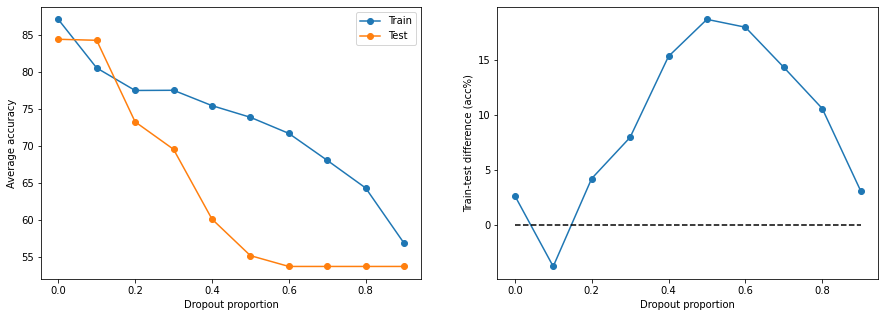

In [36]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])

ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

plt.show()

### Iris